In [1]:
import tensorflow as tf
import gym
import os.path as osp
import numpy as np
import argparse
import time
from tensorflow import keras
from tensorflow.keras import layers
import utils
import matplotlib.pyplot as plt
from numpy.random import default_rng
import itertools

/home/iggybibi/Documents/gan_test/utils.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [55]:
def generate_swirls(shape, rng):
    n = shape[-1]
    pts = shape[0:-1]
    points = np.zeros(shape=pts+[2])
    angles = rng.uniform(-np.pi, np.pi, size=pts)
    decays = rng.uniform(0.1, .2, size=pts)
#     decay = 1.0
    swirls = []
    for i in range(n):
        swirls.append(points)
        decays = decays*1.1
#         print(.shape)
        vectors = np.moveaxis(np.array([np.sin(angles), np.cos(angles)]),0,-1)/np.reshape(decays, decays.shape+(1,))
        points = points + vectors
        angles = rng.vonmises(angles+decays, 50.0*decays)
    return np.moveaxis(np.array(swirls),0,-2)

rng = default_rng()
generate_swirls([4,3,3], rng).shape

(4, 3, 3, 2)

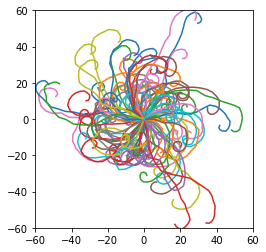

In [67]:
%matplotlib inline

def plot_swirls(swirls, ax=None):
    if ax is None:
        ax = plt.axes()
    for swirl in np.reshape(swirls,(-1,)+swirls.shape[-2:]):
        ax.plot(swirl[:,0], swirl[:,1])
        ax.set_xlim(-60,60)
        ax.set_ylim(-60,60)
        ax.set_aspect('equal')
        
def plot_directional_swirls(swirls, ax=plt):
    for swirl in np.reshape(swirls,(-1,)+swirls.shape[-2:]):
        ax.plot(swirl)

plot_swirls(generate_swirls([100,20], rng))

In [4]:
@tf.keras.utils.register_keras_serializable(package='Custom', name='p_mean')
class PMean(tf.keras.regularizers.Regularizer):
  def __init__(self, p=1.):
    self.p = p

  def __call__(self, x):
    return utils.p_mean(x, self.p)

  def get_config(self):
    return {'p': float(self.p)}

In [5]:
def generator_def(hidden_sizes: list[int], strand_size: int):
    latent_input = keras.Input(shape=(4,))

    dense = latent_input
    for hidden_size in hidden_sizes:
        dense = layers.Dense(hidden_size,
                             activation="relu",
                             kernel_regularizer=PMean(1.0))(dense)

    dense = layers.Dense(strand_size*2)(dense)
    outputs = layers.Reshape((strand_size, 2))(dense)
    model = keras.Model(
        inputs=latent_input,
        outputs=outputs,
        name="generator"
    )
    return model


In [6]:
def discriminator_def(hidden_sizes: list[int], strand_size: int, num_states: int):
    strands_input = keras.Input(shape=(num_states, strand_size, 2))
    
    dense = layers.Reshape((num_states, strand_size*2))(strands_input)
    for hidden_size in hidden_sizes:
        dense = layers.Dense(hidden_size,
                             activation="selu",
                             kernel_initializer='lecun_normal',
                             kernel_regularizer=PMean(1.0))(dense)
    flattened = layers.Flatten()(dense)
    output = layers.Dense(1, activation="sigmoid")(flattened)
    model = keras.Model(
        inputs=strands_input,
        outputs=output,
        name="discriminator"
    )
    return model

In [7]:
# def model_2d(model, extra_size):
#     inputs = [keras.Input(shape=[extra_size]+inp.shape[1:]) for inp in model.inputs]
#     inputs = keras.Input(shape=[extra_size,1])
#     outputs = layers.TimeDistributed(model)(inputs)
#     new_model = keras.Model(inputs=inputs, outputs=outputs)
#     new_model.summary()
#     return new_model
# model_2d(generator, 10)

In [8]:
@tf.function
def generate_fakes(generator, shape):
    latent = tf.random.uniform(minval=-4.0, maxval=4.0, shape=tf.concat([shape,generator.inputs[0].shape[1:]],axis=0))
    @tf.function
    def flatten_batch(b):
        return tf.reshape(b, shape=tf.concat([[-1], generator.inputs[0].shape[1:]], axis=0))

    generated = generator(flatten_batch(latent))
    unflattened = tf.concat([shape, generator.outputs[0].shape[1:]], axis=0)
    return tf.reshape(generated, shape=unflattened)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

(2, 3, 10, 2)

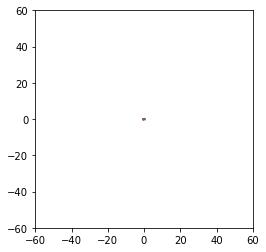

In [9]:
%matplotlib inline
bad_pts = generate_fakes(generator_def([3,3],10), [2, 3]).numpy()
plot_swirls(bad_pts)
bad_pts.shape

In [61]:
@tf.function
def gan_dfls(generator, discriminator, real_batch):
    fakes = generate_fakes(generator, tuple(real_batch.shape[0:-2]))
    fakes2 = generate_fakes(generator, tuple(real_batch.shape[0:-2]))
    fooled = utils.p_mean(discriminator(fakes), 2.0)
    discriminator_regularizer = 1 - tf.tanh(tf.reduce_mean(discriminator.losses)*10.0)
    generator_regularizer = 1 - tf.tanh(tf.reduce_mean(generator.losses)*10.0)
    real_fake_dfl = utils.DFL(0.0, {
        "real": utils.p_mean(discriminator(real_batch), 0.0),
        "fake": utils.p_mean(1 - discriminator(fakes), 0.0)
    })
    generator_dfl = utils.DFL(0.0, {
#         "fooled": utils.p_mean(discriminator(fakes2),2.0)
        "fooled": utils.smooth_constraint(utils.p_mean(discriminator(fakes2), 2.0), 0.0, 0.5, 0.0, 0.97, starts_linear=True),
        "reg": tf.where(tf.stop_gradient(utils.dfl_scalar(real_fake_dfl)) < 0.1, generator_regularizer, 1.0)
    })
    
    discriminator_dfl = utils.DFL(0.0, {
        "rf": real_fake_dfl,
        "reg": tf.where(tf.stop_gradient(fooled) < 0.1, discriminator_regularizer, 1.0)
    })
    return generator_dfl, discriminator_dfl


def train_step(generator, discriminator, gen_lr, disc_lr):
    gen_optimizer = keras.optimizers.Adam(lr=gen_lr)
    disc_optimizer = keras.optimizers.Adam(lr=disc_lr)

    @tf.function
    def gradient_step(batch):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generator_dfl, discriminator_dfl = gan_dfls(generator, discriminator, batch)
            generator_scalar = utils.dfl_scalar(generator_dfl)
            generator_loss = 1-generator_scalar
            discriminator_scalar = utils.dfl_scalar(discriminator_dfl)
            discriminator_loss = 1-discriminator_scalar
        
        disc_grads = disc_tape.gradient(discriminator_loss, discriminator.trainable_weights)
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_weights))
        
        gen_grads = gen_tape.gradient(generator_loss, generator.trainable_weights)
        gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_weights))
        return (generator_scalar, generator_dfl), (discriminator_scalar, discriminator_dfl)

    def train_and_show(batch):
        generator_info, discriminator_info = gradient_step(batch)
        return f"D[{show_info(discriminator_info)}], G[{show_info(generator_info)}]"

    return train_and_show


def show_info(scalar_dfl):
    scalar, dfl = scalar_dfl
    return f"{scalar:.2e}|{utils.format_dfl(dfl)}"

In [62]:
swirl_size = 10
num_swirls_per_discrimination = 1
generator = generator_def([100,100], swirl_size)
generator.summary()
discriminator = discriminator_def([100,100], swirl_size, num_swirls_per_discrimination)
discriminator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_46 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_47 (Dense)             (None, 20)                2020      
_________________________________________________________________
reshape_15 (Reshape)         (None, 10, 2)             0         
Total params: 12,620
Trainable params: 12,620
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator"
_________________________________________________________________
Layer (type)                 O


Start of epoch 0


  0%|          | 0/1000 [00:00<?, ?it/s]

[]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

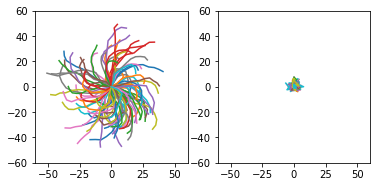

Time taken: 9.16s

Start of epoch 1


  0%|          | 0/1000 [00:00<?, ?it/s]

[]

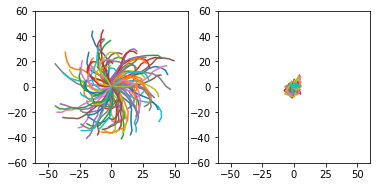

Time taken: 3.32s

Start of epoch 2


  0%|          | 0/1000 [00:00<?, ?it/s]

[]

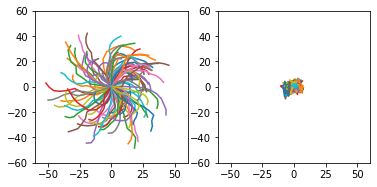

Time taken: 3.37s

Start of epoch 3


  0%|          | 0/1000 [00:00<?, ?it/s]

[]

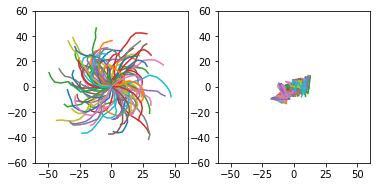

Time taken: 3.08s

Start of epoch 4


  0%|          | 0/1000 [00:00<?, ?it/s]

[]

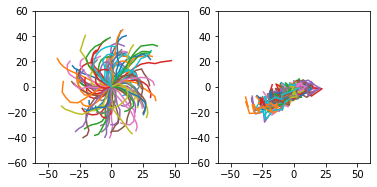

Time taken: 3.42s

Start of epoch 5


  0%|          | 0/1000 [00:00<?, ?it/s]

[]

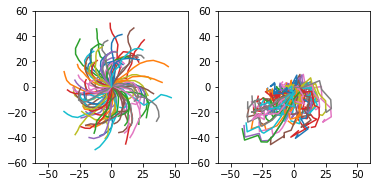

Time taken: 3.39s

Start of epoch 6


  0%|          | 0/1000 [00:00<?, ?it/s]

[]

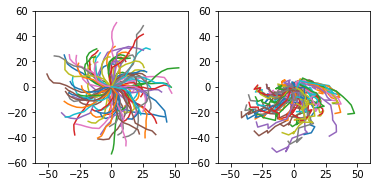

Time taken: 3.58s

Start of epoch 7


  0%|          | 0/1000 [00:00<?, ?it/s]

[]

KeyboardInterrupt: 

In [63]:
%matplotlib inline

def end_of_epoch(epoch, time):
    fake_pts = generate_fakes(generator, [100]).numpy()
    fig, axs = plt.subplot_mosaic([['real', 'fake']])
    plot_swirls(fake_pts, axs['fake'])
    plot_swirls(generate_swirls([100,10], default_rng()), axs['real'])
    plt.show()

def create_dataset(rng=default_rng(), num_epochs=20, batch_size = 30, num_batches = 1000):
    for i in range(num_epochs):
        yield generate_swirls([num_batches, batch_size, num_swirls_per_discrimination, swirl_size],rng)
        
def train(dataset, gen_lr, disc_lr):
    utils.train_loop(dataset, train_step(generator, discriminator, gen_lr, disc_lr), end_of_epoch)
# train(create_dataset(num_epochs=1), 1e-3, 1e-3)
train(create_dataset(num_epochs=20), 1e-4, 1e-4)
train(create_dataset(num_epochs=20, batch_size=30), 1e-4, 1e-4)
train(create_dataset(num_epochs=10, batch_size=100), 1e-5, 1e-5)

In [ ]:
%matplotlib inline
train(create_dataset(num_epochs=20, batch_size=100), 1e-5, 1e-5)

<IPython.core.display.Javascript object>


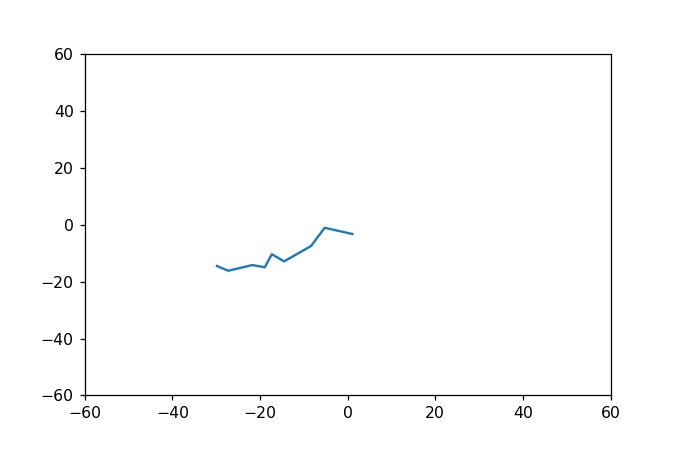

interactive(children=(FloatSlider(value=0.0, description='l0', max=4.0, min=-4.0), FloatSlider(value=0.0, desc…

<function __main__.update(**kwargs)>

In [71]:
%matplotlib notebook
import ipywidgets

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(np.zeros(shape=10))
ax.set_ylim([-60, 60])
ax.set_xlim([-60, 60])


def update(**kwargs):
    generated = generator(np.array([list(kwargs.values())]))
    line.set_xdata(generated[0,:,0])
    line.set_ydata(generated[0,:,1])
    fig.canvas.draw_idle()

ipywidgets.interact(update, **{f"l{i}": (-4.0,4.0) for i in range(generator.inputs[0].shape[1])})

<IPython.core.display.Javascript object>


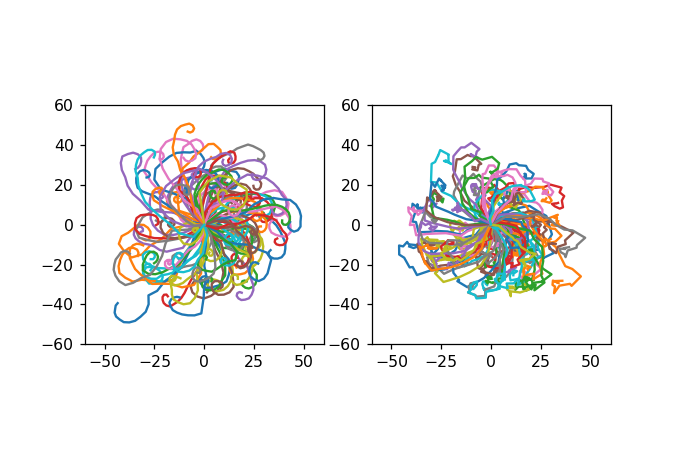

In [15]:
%matplotlib notebook
end_of_epoch(1,1)